In [1]:
import os
import re
import pandas as pd
import numpy as np
import nltk
import pickle

%load_ext autoreload
%autoreload 2

import parent_modules
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import pairwise_distances

from definitions import *
from helpers import *
from baseline_cf import *

# Load Movielens dataset for Item -Item Similarities
movielens_dataset = MovieLensRatingsDataset()
movielens_dataset_small = MovieLensRatingsDataset(keep=0.1)


## Simillarities

In [2]:
# Jaccard Similarity
movielens_dataset.jaccard_similarity.head()

/home/giannhs/miniconda3/envs/text_analytics_2/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1575: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


movieId,1,2,3,5,6,7,9,10,11,12,...,159093,164179,166528,168250,168252,174055,176371,177765,179819,187593
movieId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.301887,0.142857,0.129730,0.248826,0.132979,0.039548,0.296804,0.203046,0.067797,...,0.027778,0.076923,0.069892,0.038889,0.065934,0.045198,0.050000,0.027933,0.033898,0.027933
2,0.301887,1.000000,0.200000,0.161017,0.220126,0.128000,0.027523,0.325000,0.178571,0.073394,...,0.027273,0.097345,0.104348,0.036036,0.119266,0.046296,0.083333,0.018182,0.037383,0.046729
3,0.142857,0.200000,1.000000,0.222222,0.165217,0.246154,0.130435,0.169231,0.129032,0.187500,...,0.000000,0.049180,0.046875,0.018519,0.050847,0.039216,0.055556,0.000000,0.020000,0.000000
5,0.129730,0.161017,0.222222,1.000000,0.154545,0.298246,0.097561,0.150794,0.166667,0.086957,...,0.022222,0.055556,0.052632,0.021277,0.037736,0.022222,0.041667,0.000000,0.023256,0.000000
6,0.248826,0.220126,0.165217,0.154545,1.000000,0.149123,0.062500,0.311688,0.192308,0.080808,...,0.030000,0.096154,0.083333,0.029412,0.076923,0.040404,0.070000,0.000000,0.020202,0.030303


In [3]:
# Pearson Similarity
movielens_dataset.pearson_similarity.head()

movieId,1,2,3,5,6,7,9,10,11,12,...,159093,164179,166528,168250,168252,174055,176371,177765,179819,187593
movieId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.178983,0.136128,0.153725,0.122948,0.099621,0.112117,0.185387,0.144952,0.149678,...,-0.016475,0.079961,0.028192,0.018223,0.057158,0.061225,0.057341,-0.010076,0.051466,0.014426
2,0.178983,1.000000,0.173598,0.179390,0.101651,0.104321,-0.023199,0.258169,0.124763,0.082600,...,0.009875,0.129452,0.145067,0.022873,0.219752,0.048388,0.154305,-0.033434,0.110026,0.117877
3,0.136128,0.173598,1.000000,0.359519,0.122400,0.373282,0.254815,0.129034,0.164854,0.202242,...,-0.055394,-0.008482,-0.016528,-0.043928,-0.004138,0.045740,0.033977,-0.050395,0.024357,-0.053386
5,0.153725,0.179390,0.359519,1.000000,0.135922,0.458714,0.216356,0.144774,0.203560,0.117635,...,0.020997,0.006304,0.002984,-0.003354,-0.022626,-0.003864,0.002731,-0.045835,-0.001546,-0.048556
6,0.122948,0.101651,0.122400,0.135922,1.000000,0.100664,0.138454,0.254995,0.159150,0.131322,...,0.017029,0.127574,0.083804,0.029891,0.106940,0.073934,0.124326,-0.082322,0.000549,0.028282


In [4]:
# Cosine Similarity
movielens_dataset.cosine_similarity.head()

movieId,1,2,3,5,6,7,9,10,11,12,...,159093,164179,166528,168250,168252,174055,176371,177765,179819,187593
movieId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.446971,0.305854,0.302137,0.396841,0.271328,0.183813,0.463520,0.358906,0.225869,...,0.095783,0.213547,0.184635,0.130367,0.190300,0.152449,0.169952,0.090992,0.137871,0.114891
2,0.446971,1.000000,0.301151,0.294109,0.317119,0.237974,0.056544,0.452402,0.295874,0.157833,...,0.090493,0.226755,0.246286,0.108297,0.298076,0.122652,0.228011,0.046223,0.169823,0.179888
3,0.305854,0.301151,1.000000,0.418275,0.253466,0.433397,0.287134,0.269804,0.268005,0.244136,...,0.000000,0.066637,0.063582,0.015093,0.067422,0.094188,0.092896,0.000000,0.070658,0.000000
5,0.302137,0.294109,0.418275,1.000000,0.253221,0.506340,0.248879,0.269911,0.293094,0.161519,...,0.067381,0.074178,0.075035,0.048315,0.044274,0.043489,0.058785,0.000000,0.042411,0.000000
6,0.396841,0.317119,0.253466,0.253221,1.000000,0.229346,0.193095,0.441042,0.316268,0.197054,...,0.093126,0.221449,0.190364,0.110655,0.199210,0.141733,0.199744,0.000000,0.072779,0.100128


In [5]:
# Hamming Similarity
movielens_dataset.hamming_similarity.head()

movieId,1,2,3,5,6,7,9,10,11,12,...,159093,164179,166528,168250,168252,174055,176371,177765,179819,187593
movieId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.490909,0.524675,0.532468,0.488312,0.519481,0.537662,0.462338,0.503896,0.537662,...,0.537662,0.532468,0.529870,0.537662,0.532468,0.542857,0.535065,0.532468,0.537662,0.532468
2,0.490909,1.000000,0.703896,0.701299,0.615584,0.690909,0.714286,0.631169,0.651948,0.719481,...,0.714286,0.709091,0.703896,0.714286,0.716883,0.716883,0.719481,0.714286,0.719481,0.724675
3,0.524675,0.703896,1.000000,0.854545,0.711688,0.838961,0.880519,0.667532,0.758442,0.880519,...,0.859740,0.841558,0.833766,0.857143,0.846753,0.864935,0.857143,0.862338,0.862338,0.862338
5,0.532468,0.701299,0.854545,1.000000,0.724675,0.867532,0.893506,0.680519,0.781818,0.883117,...,0.880519,0.857143,0.849351,0.875325,0.859740,0.880519,0.872727,0.880519,0.880519,0.880519
6,0.488312,0.615584,0.711688,0.724675,1.000000,0.719481,0.753247,0.649351,0.685714,0.745455,...,0.740260,0.732468,0.729870,0.737662,0.740260,0.742857,0.740260,0.735065,0.740260,0.742857


## Datasets Generation

### Generate CF, User-Similarities, Categories for 100% of the Dataset

In [6]:
# Calculate Baseline Df
# Read the Commends for the baseline_cf module functionality
baseline_cf_matrix = load_baseline_cf(
    from_pickle=True,
    df=movielens_dataset.full_df)
baseline_cf_matrix.shape

(385, 2221)

In [7]:
# Load Movielens dataset for User - User Similarities
movielens_user_based = MovieLensRatingsDataset(user_based=True)
movielens_user_based.pivot_df.shape

(2221, 385)

In [8]:
movie_ids = movielens_dataset.df["movieId"].unique()
categories = CategoriesDataset(movie_ids, 10)
categories_df = categories.categories_df
categories_df.head()

,0,1,2,3,4,5,6,7,8,9,...,235,236,237,238,239,240,241,242,243,244
0,5,11,14,18,33,41,49,72,88,92,...,2103,2105,2110,2134,2149,2161,2162,2172,2177,2211
1,28,30,48,50,55,56,58,115,144,159,...,0,0,0,0,0,0,0,0,0,0
2,0,6,15,20,29,65,73,103,109,117,...,0,0,0,0,0,0,0,0,0,0
3,1,3,26,43,46,61,71,75,80,82,...,0,0,0,0,0,0,0,0,0,0
4,39,44,45,53,59,66,67,81,86,87,...,0,0,0,0,0,0,0,0,0,0


### Generate CF, User-Similarities, Categories for x% partion of the Dataset

In [9]:
small_cf_pathname = os.path.join(MODELS_DIR, "baseline-cf-pickle-small")
baseline_cf_matrix_small = load_baseline_cf(
    from_pickle=False,
    pickle_file_name = small_cf_pathname,
    df=movielens_dataset_small.full_df)
baseline_cf_matrix_small.head()

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 1.2152
Item-based Model : Test Set - 1.2152303374212778
RMSE: 1.0464
Item-based Model : Training Set - 1.0464294733623956


movieId,24,31,41,69,88,157,165,169,173,227,...,102481,108932,116797,116823,134130,135887,152081,164179,166528,187593
userId,,,,,,,,,,,,,,,,,,,,,
11,1.0,1.0,1.0,1.0,1.0,1.0,1.763109,1.0,1.000000,1.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
42,1.0,1.0,1.0,1.0,1.0,1.0,2.081436,1.0,1.460819,2.709975,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
64,1.0,1.0,1.0,1.0,1.0,1.0,1.172163,1.0,1.000000,1.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
79,1.0,1.0,1.0,1.0,1.0,1.0,1.328724,1.0,1.000000,1.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
99,1.0,1.0,1.0,1.0,1.0,1.0,2.521185,1.0,1.000000,1.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [10]:
movielens_user_based_small = MovieLensRatingsDataset(
    df=movielens_dataset_small.full_df,
    preprocess_df=False,
    user_based=True
)
movielens_user_based_small.pivot_df.head()

userId,11,42,64,79,99,140,149,186,195,233,...,437,462,475,483,528,541,584,599,600,602
movieId,,,,,,,,,,,,,,,,,,,,,
24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.5,0.0,0.0,0.0,2.5,2.0,0.0
31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0
41,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0
69,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0
88,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0


In [11]:
movie_ids_small = movielens_dataset_small.df["movieId"].unique()
categories_small = CategoriesDataset(movie_ids_small, 5)
categories_df_small = categories_small.categories_df
categories_df_small

,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,8,11,18,19,23,24,37,42,46,48,...,203,0,0,0,0,0,0,0,0,0
1,1,9,10,17,20,21,22,26,32,33,...,193,204,0,0,0,0,0,0,0,0
2,5,6,12,28,34,38,44,56,66,69,...,0,0,0,0,0,0,0,0,0,0
3,0,2,4,13,16,25,27,35,36,39,...,161,162,167,168,174,179,187,196,200,201
4,3,7,14,15,29,30,31,41,45,47,...,188,0,0,0,0,0,0,0,0,0


## Problem-A definition and Solution

In [12]:
from pyomo.environ import *
from pyomo.solvers import plugins
from problem_a import *
from itertools import product

L_choices = [5]
K_choices = [0.03, 0.05, 0.07, 0.1, 0.2]
D_choices = [0.1, 0.5, 1, 1.5, 2]

# L_choices = [5]
# K_choices = [0.03, 0.05]
# D_choices = [0.5, 1]

prob_a_param_products = [prd for prd in product(L_choices, K_choices, D_choices)]

### Continuous Solution

In [13]:
run_res = []
for L, K, D in prob_a_param_products:
    try:
        model_small_cont = create_pyomo_model(
            baseline_cf_matrix_small,
            categories_df_small,
            movielens_user_based_small.pearson_similarity,
            L,
            K,
            D,
            UnitInterval
        )
        solver_small_cont = SolverFactory("ipopt")
        solver_small_cont.options["max_cpu_time"] = 15
        solution_small_cont = solver_small_cont.solve(model_small_cont)
        l_const, cover_const, div_const = test_constraints(
            model_small_cont, baseline_cf_matrix_small, categories_df_small, L, K, D
        )
        ratings_average = ProblemAPredictionsMatrix(
            bs_matrix=baseline_cf_matrix_small,
            x_var_pred=model_small_cont.x,
            L=L
        ).predictions_average
    except Exception as e:
        print(f"Exception while optimizing for combination ({L}, {K}, {D})")
        ratings_average = 0
        l_const = cover_const = div_const = False
        
    run_res.append(
    {
        "ratings_average": ratings_average,
        "L": L,
        "K": K,
        "D": D,
        "L_Constraint": l_const,
        "Coverage_Constraint": cover_const,
        "Diversity_Constraint": div_const,
        "Satisfies_Constraints": l_const and cover_const and div_const
    })
continous_res_df = pd.DataFrame(run_res)

    model=unknown;
        message from solver=Ipopt 3.12.13\x3a Maximum CPU Time Exceeded.
    model=unknown;
        message from solver=Ipopt 3.12.13\x3a Maximum CPU Time Exceeded.
    model=unknown;
        message from solver=Ipopt 3.12.13\x3a Maximum CPU Time Exceeded.
    model=unknown;
        message from solver=Ipopt 3.12.13\x3a Maximum CPU Time Exceeded.
    model=unknown;
        message from solver=Ipopt 3.12.13\x3a Maximum CPU Time Exceeded.
    model=unknown;
        message from solver=Ipopt 3.12.13\x3a Maximum CPU Time Exceeded.
    model=unknown;
        message from solver=Ipopt 3.12.13\x3a Maximum CPU Time Exceeded.
    model=unknown;
        message from solver=Ipopt 3.12.13\x3a Maximum CPU Time Exceeded.
    model=unknown;
        message from solver=Ipopt 3.12.13\x3a Maximum CPU Time Exceeded.
    model=unknown;
        message from solver=Ipopt 3.12.13\x3a Maximum CPU Time Exceeded.
    model=unknown;
        message from solver=Ipopt 3.12.13\x3a Maximum CPU Tim

In [14]:
continous_res_df

,ratings_average,L,K,D,L_Constraint,Coverage_Constraint,Diversity_Constraint,Satisfies_Constraints
0,1.791600,5,0.03,0.1,True,False,True,False
1,1.793893,5,0.03,0.5,True,False,True,False
2,1.769238,5,0.03,1.0,True,False,True,False
3,1.793893,5,0.03,1.5,True,False,True,False
4,1.791600,5,0.03,2.0,True,False,True,False
5,1.659095,5,0.05,0.1,True,False,True,False
6,1.770002,5,0.05,0.5,True,False,True,False
7,1.752555,5,0.05,1.0,True,False,True,False
8,1.766344,5,0.05,1.5,True,False,True,False
9,1.796078,5,0.05,2.0,True,False,True,False


### Plot Parameterized runs for D, K

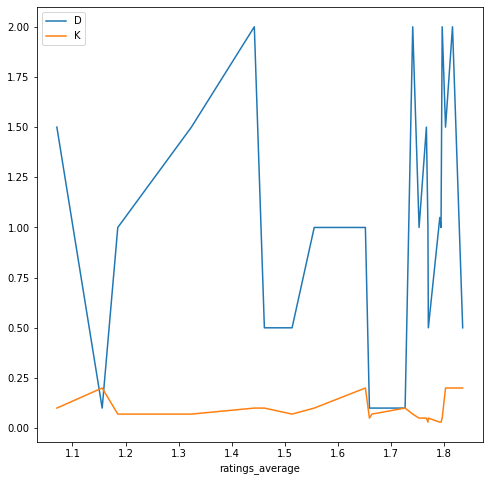

In [15]:
%matplotlib inline
d_lines = continous_res_df.groupby("ratings_average").mean()[["D", "K"]].plot.line(figsize=(8,8))
d_lines_fig = d_lines.get_figure()
d_lines_fig.savefig(os.path.join(RESULTS_DIR, "continuous_D_K_average"))
d_lines

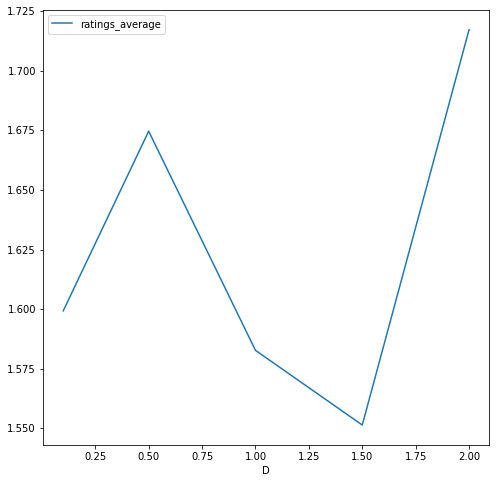

In [16]:
%matplotlib inline
d_lines = continous_res_df.groupby("D").mean().plot.line(y='ratings_average', figsize=(8,8))
d_lines_fig = d_lines.get_figure()
d_lines_fig.savefig(os.path.join(RESULTS_DIR, "continuous_D_average"))
d_lines

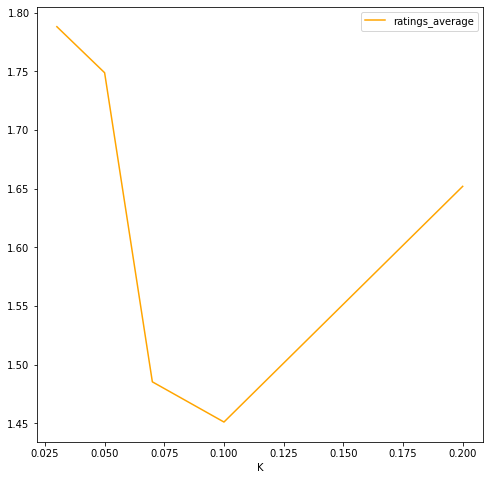

In [17]:
%matplotlib inline
d_lines = continous_res_df.groupby("K").mean().plot.line(y='ratings_average', figsize=(8,8), color="orange")
d_lines_fig = d_lines.get_figure()
d_lines_fig.savefig(os.path.join(RESULTS_DIR, "continuous_K_average"))
d_lines

### Estimate Best model

In [18]:
best_model = continous_res_df.sort_values(["Satisfies_Constraints","ratings_average"],
                                          ascending=False).head(1)
best_model

,ratings_average,L,K,D,L_Constraint,Coverage_Constraint,Diversity_Constraint,Satisfies_Constraints
21,1.834658,5,0.2,0.5,True,False,False,False


In [19]:
model_small_cont = create_pyomo_model(
    baseline_cf_matrix_small,
    categories_df_small,
    movielens_user_based_small.pearson_similarity,
    best_model["L"].values[0],
    best_model["K"].values[0],
    best_model["D"].values[0],
    UnitInterval
)
solver_small_cont = SolverFactory("ipopt")
# solver_small_cont.options["max_cpu_time"] = 300
solution_small_cont = solver_small_cont.solve(model_small_cont)

In [27]:
solution_small_cont

{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 48, 'Number of variables': 7790, 'Sense': 'unknown'}], 'Solver': [{'Status': 'ok', 'Message': 'Ipopt 3.12.13\\x3a Solved To Acceptable Level.', 'Termination condition': 'optimal', 'Id': 1, 'Error rc': 0, 'Time': 54.797443151474}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

####  Validating the solution Constraints

In [20]:
l_const, cover_const, div_const = test_constraints(
    model_small_cont, 
    baseline_cf_matrix_small, 
    categories_df_small, 
    best_model["L"].values[0],
    best_model["K"].values[0],
    best_model["D"].values[0],
    verbose=True
)

---Test Maximum Recommendation Limit-----
Maximum Recommendation Limit Constraint is satisfied
---Test Coverage-----
Category 0 - Coverage=0.20000000000000026
Category 1 - Coverage=0.19999999999999854
Category 2 - Coverage=0.20000000000000037
Category 3 - Coverage=0.2000000000000003
Category 4 - Coverage=0.19999999999999946
Coverage Constraint is satisfied
---Test Diversity-----
Category 0 - Diversity=0.5000004054463459
Category 1 - Diversity=0.5000000828539906
Category 2 - Diversity=0.5000009388858128
Category 3 - Diversity=0.4999999963729444
Category 4 - Diversity=1.6578399554797625
Diversity Constraint is satisfied


#### Calculating the average Rating

In [21]:
ratings_average = ProblemAPredictionsMatrix(
    bs_matrix=baseline_cf_matrix_small,
    x_var_pred=model_small_cont.x,
    L=L
)
ratings_average.predictions_average

2.154928392020694

### Binary Solution

In [22]:
model_small_bin = create_pyomo_model(baseline_cf_matrix_small,
                                      categories_df_small,
                                      movielens_user_based_small.pearson_similarity,
                                      L,
                                      K,
                                      D,
                                      Boolean)

In [23]:
solver_small_bin = SolverFactory('ipopt')
solver_small_bin.options['max_cpu_time'] = 100
solver_small_bin = solver_small_bin.solve(model_small_bin)
solver_small_bin

    model=unknown;
        message from solver=Ipopt 3.12.13\x3a Maximum CPU Time Exceeded.


{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 48, 'Number of variables': 7790, 'Sense': 'unknown'}], 'Solver': [{'Status': 'warning', 'Message': 'Ipopt 3.12.13\\x3a Maximum CPU Time Exceeded.', 'Termination condition': 'maxIterations', 'Id': 401, 'Error rc': 0, 'Time': 42.09915041923523}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [24]:
model_small_bin

In [25]:
test_constraints(
    model_small_bin,
    baseline_cf_matrix_small,
    categories_df_small,
    L,
    K,
    D
)

(True, True, False)

In [26]:
from pyomo.solvers.plugins.solvers.gurobi_persistent import GurobiPersistent
gurobi_persi = GurobiPersistent(model=model_ins)
solution_small = gurobi_persi.solve(tee=True, options={
    'Heuristics': 0.5,
    'MIPFocus': 2,
    'Threads': 3,
    'SubMIPNodes': 100000000,
    'MIQCPMethod': 0,
    'PreMIQCPForm': 1,
#     'PreQLinearize': 2,
    'Presolve': 2,
    'Aggregate': 1,
    'InfUnbdInfo': 1
})

NameError: name 'model_ins' is not defined